# KOSPI200 Volatility Estimation

객체지향 프로그래밍 패러다임(OOP, Object-Oriented Programming)기반 작성

총 8개 volatility estimate class가 존재

**close-close based**

1. MovingWindow 
2. ARCH 
3. EWMA 
4. GARCH 
5. TraditionalCtoC

**range-based**

6. Parkinson 
7. GarmanKlass 
8. RogersSatchell 

20개년도 데이터에 대해 10일(영업일 기준 2주)단위의 sliding window 방식으로 vol을 추정했으며,

최근 90일 동안의 변화를 나타냄

* 차후 개선 : 미래 vol에 대한 예측을 추가

### Package Import

In [21]:
!pip install pykrx

In [22]:
# !pip install -r 'requirements.txt'

In [23]:
#data crawling
from urllib.request import urlopen
import bs4
import datetime as dt
from pykrx import stock

#data preprocessing and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go


from abc import * #클래스
from arch import arch_model

### Data Crawling with BeautifulSoup
* 20개년도 데이터 수집에 약 7분

In [24]:
'''def date_format(d) :
    d = d.replace('.','-')
    return dt.datetime.strptime(d, "%Y-%m-%d").date()

def historical_index_naver(index_cd, start_date='',end_date='',page_n = 1, last_page=0) -> pd.DataFrame:
    historical_prices = {'Date' : [],'Close' : []}
    naver_index = "https://finance.naver.com/sise/sise_index_day.naver?code=" + index_cd + "&page=" + str(page_n)
    source = urlopen(naver_index).read()
    source = bs4.BeautifulSoup(source, 'lxml')
    if last_page == 0:
        last_page = source.find('td',class_='pgRR').find("a")['href']
        
        last_page = last_page.split("&")[1]
        last_page = last_page.split("=")[1]
        last_page = int(last_page)
    if start_date:
        start_date = date_format(start_date)
    else:
        start_date = dt.date.today()
        
    if end_date:
        end_date = date_format(end_date)
    else:
        end_date = dt.date.today()
    while page_n < last_page :
            
        naver_index = "https://finance.naver.com/sise/sise_index_day.naver?code=" + index_cd + "&page=" + str(page_n)
        
        source = urlopen(naver_index).read()
        source = bs4.BeautifulSoup(source, 'lxml')

        dates = source.find_all('td', class_='date')
        prices = source.find_all("td", class_="number_1")
        
        for n in range(len(dates)):
            if dates[n].text.split('.')[0].isdigit():
                this_date = dates[n].text
                this_date = date_format(this_date)
                
                if this_date <= end_date and this_date >= start_date:
                    this_close = prices[n*4].text
                    this_close = this_close.replace(",","")
                    this_close = float(this_close)
                    
                    historical_prices['Date'].append(this_date)
                    historical_prices['Close'].append(this_close)
                    
                elif this_date <= start_date:
                    return historical_prices
        page_n = page_n + 1
    historical_prices=pd.DataFrame(historical_prices)
    return historical_prices'''

'def date_format(d) :\n    d = d.replace(\'.\',\'-\')\n    return dt.datetime.strptime(d, "%Y-%m-%d").date()\n\ndef historical_index_naver(index_cd, start_date=\'\',end_date=\'\',page_n = 1, last_page=0) -> pd.DataFrame:\n    historical_prices = {\'Date\' : [],\'Close\' : []}\n    naver_index = "https://finance.naver.com/sise/sise_index_day.naver?code=" + index_cd + "&page=" + str(page_n)\n    source = urlopen(naver_index).read()\n    source = bs4.BeautifulSoup(source, \'lxml\')\n    if last_page == 0:\n        last_page = source.find(\'td\',class_=\'pgRR\').find("a")[\'href\']\n        \n        last_page = last_page.split("&")[1]\n        last_page = last_page.split("=")[1]\n        last_page = int(last_page)\n    if start_date:\n        start_date = date_format(start_date)\n    else:\n        start_date = dt.date.today()\n        \n    if end_date:\n        end_date = date_format(end_date)\n    else:\n        end_date = dt.date.today()\n    while page_n < last_page :\n            \n

In [25]:
'''index_cd = "KPI200"
historical_prices = historical_index_naver(index_cd, "2020-3-1", "2024-3-21")'''

'index_cd = "KPI200"\nhistorical_prices = historical_index_naver(index_cd, "2020-3-1", "2024-3-21")'

### Data Crawling with PyKrx
* 20개년도 데이터 수집에 약 10초

In [26]:
historical_prices = stock.get_index_ohlcv("20050327", "20240327", "1028")
historical_prices = historical_prices.drop(columns=['거래량', '거래대금', '상장시가총액'])
historical_prices.reset_index(inplace=True,drop=False)
historical_prices.columns = ['Date','Open','High','Low','Close']
historical_prices.head(3)

,Date,Open,High,Low,Close
0,2005-03-28,125.61,127.17,125.61,126.72
1,2005-03-29,126.65,126.72,123.73,124.13
2,2005-03-30,123.26,123.87,122.51,123.49


## Close-Close Based Estimators

In [27]:
class Abstract_VolEstimator(metaclass=ABCMeta):
    #abstract variable
    data = pd.DataFrame
    window_size = 0
    visualize_size=90
    def __init__(self, data, window_size,visualize_size=90) :
        self.data = data.sort_values(by='Date')
        self.data.reset_index(inplace=True, drop=True)
        self.window_size = window_size
        self.cal_return()
        self.visualize_size = visualize_size
        
    def cal_return(self):
        self.data['Daily Return'] = self.data['Close'].pct_change()

    def cal_window_size_Variance(self) :
        self.cal_return()
        self.data['window_size Variance'] = self.data['Daily Return'].pow(2).rolling(window=self.window_size).sum()/self.window_size
    
    def cal_annualized_volatility(self) :
        self.data[f'{self.__class__.__name__}_Vol'] = self.data[f'{self.__class__.__name__}_Var'].pow(0.5)*(252**0.5)
        
    def visualize(self):
        plt.figure(figsize=(10,6))
        plt.plot(self.data['Date'][-self.visualize_size:],self.data[f'{self.__class__.__name__}_Vol'][-self.visualize_size:], label= f'window size {self.window_size}')
        plt.title(f'Recent {self.visualize_size} days window_size Volatility of {self.__class__.__name__} method')
        plt.show()
        
    #abstract method
    @abstractmethod
    def estimate(self):
        pass

### MovingWindow
$$
\sigma_{moving}=\sqrt{\frac{1}{N}\sum^N_{i=1}R^2_i}
$$

In [28]:
class MovingWindow(Abstract_VolEstimator):
    def estimate(self) :
        self.cal_window_size_Variance()
        self.data[f'{self.__class__.__name__}_Vol'] = self.data[f'window_size Variance'].pow(0.5)*np.sqrt(252)

,Date,Open,High,Low,Close,Daily Return,window_size Variance,MovingWindow_Vol
0,2005-03-28,125.61,127.17,125.61,126.72,NaN,NaN,NaN
1,2005-03-29,126.65,126.72,123.73,124.13,-0.020439,NaN,NaN
2,2005-03-30,123.26,123.87,122.51,123.49,-0.005156,NaN,NaN
3,2005-03-31,125.31,125.40,124.26,124.78,0.010446,NaN,NaN
4,2005-04-01,124.65,127.07,124.61,126.88,0.016830,NaN,NaN
5,2005-04-04,126.77,127.29,126.15,127.22,0.002680,NaN,NaN
6,2005-04-06,127.61,128.20,126.18,127.85,0.004952,NaN,NaN
7,2005-04-07,128.23,128.42,127.46,127.92,0.000548,NaN,NaN
8,2005-04-08,128.86,129.01,128.12,128.44,0.004065,NaN,NaN
9,2005-04-11,127.95,127.96,127.09,127.59,-0.006618,NaN,NaN


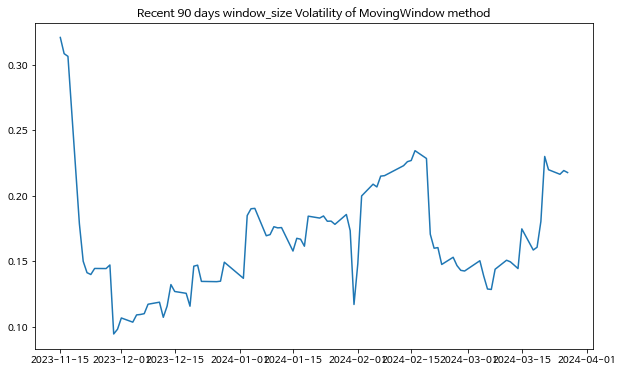

In [29]:
estimator = MovingWindow(historical_prices,10)
estimator.estimate()
display(estimator.data.head(20))
estimator.visualize()

### ARCH
$$
\sigma_n=\sqrt{\alpha\bar\sigma^2+(1-\alpha)\frac{1}{n}\sum^n_{i=1}R^2_i}
$$

In [30]:
class ARCH(Abstract_VolEstimator):
    def __init__(self, data, window_size, alpha, visualize_size=90):
        super().__init__(data, window_size, visualize_size)
        self.alpha = alpha

    def cal_long_run_vol(self):
        self.LongRunVol = self.data['window_size Variance'][:self.visualize_size].mean()
    
    def estimate(self, UseModel=False):
        if not UseModel :
            self.cal_window_size_Variance()
            self.cal_long_run_vol()
            self.data[f'{self.__class__.__name__}_Var'] = self.alpha*self.LongRunVol+(1-self.alpha)*self.data['window_size Variance']
            self.cal_annualized_volatility()
        else :
            model = arch_model(self.data['Daily Return'][1:]*100, vol='ARCH') #모델 적합을 위해 100을 곱해 스케일 조정
            model_fit = model.fit(disp='off')
            display(model_fit.summary())
            result = np.array(model_fit.conditional_volatility/100)*(252**0.5) #다시 100으로 나누어 원래의 스케일로 조정
            tmp =[np.NaN]*(len(self.data)-len(result))
            result = np.concatenate((tmp,result))
            self.data[f'{self.__class__.__name__}_Vol_package'] = result

,Date,Open,High,Low,Close,Daily Return,window_size Variance,ARCH_Var,ARCH_Vol
0,2005-03-28,125.61,127.17,125.61,126.72,NaN,NaN,NaN,NaN
1,2005-03-29,126.65,126.72,123.73,124.13,-0.020439,NaN,NaN,NaN
2,2005-03-30,123.26,123.87,122.51,123.49,-0.005156,NaN,NaN,NaN
3,2005-03-31,125.31,125.40,124.26,124.78,0.010446,NaN,NaN,NaN
4,2005-04-01,124.65,127.07,124.61,126.88,0.016830,NaN,NaN,NaN


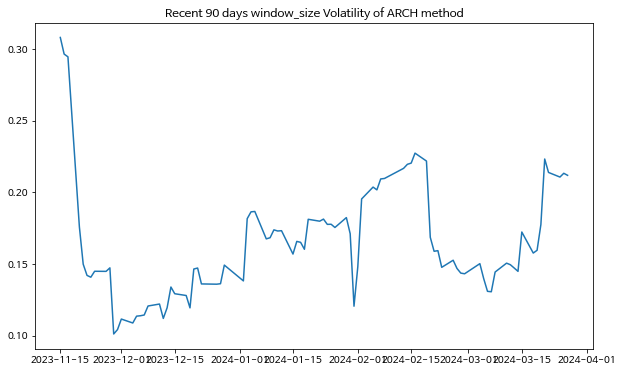

In [31]:
estimator = ARCH(historical_prices,10,0.1)
estimator.estimate()
display(estimator.data.head(5))
estimator.visualize()

### EWMA
$$
\sigma_n=\sqrt{(1-\lambda)\sum^{\infin}_{i=1}\lambda^{i-1}R^2_{n-i+1}}
$$
$$
\sigma_n=\sqrt{\lambda\sigma^2_{n-1}+(1-\lambda)R^2_n}
$$

In [32]:
class EWMA(Abstract_VolEstimator):
    def __init__(self, data, window_size, Lambda, visualize_size=90):
        super().__init__(data, window_size, visualize_size)
        self.Lambda = Lambda

    def estimate(self):
        self.cal_window_size_Variance()
        ini_var = self.data['window_size Variance'][self.window_size]
        sigma_squared_values = [np.NAN]*(self.window_size-1)+[ini_var]  # 초기 변동성의 제곱값을 리스트에 추가
        R_squared_values = self.data['Daily Return'].pow(2)[self.window_size:]
        #print(sigma_squared_values)
        #print(R_squared_values)
        # if 조건문 넣을지
        # R_squared_values를 순회하며 점화식에 따라 변동성의 제곱값을 계산
        for R_squared in R_squared_values:
            new_sigma_squared = self.Lambda * sigma_squared_values[-1] + (1 - self.Lambda) * R_squared
            sigma_squared_values.append(new_sigma_squared)
        self.data[f'{self.__class__.__name__}_Var'] = sigma_squared_values
        self.cal_annualized_volatility()

,Date,Open,High,Low,Close,Daily Return,window_size Variance,EWMA_Var,EWMA_Vol
0,2005-03-28,125.61,127.17,125.61,126.72,NaN,NaN,NaN,NaN
1,2005-03-29,126.65,126.72,123.73,124.13,-0.020439,NaN,NaN,NaN
2,2005-03-30,123.26,123.87,122.51,123.49,-0.005156,NaN,NaN,NaN
3,2005-03-31,125.31,125.40,124.26,124.78,0.010446,NaN,NaN,NaN
4,2005-04-01,124.65,127.07,124.61,126.88,0.016830,NaN,NaN,NaN


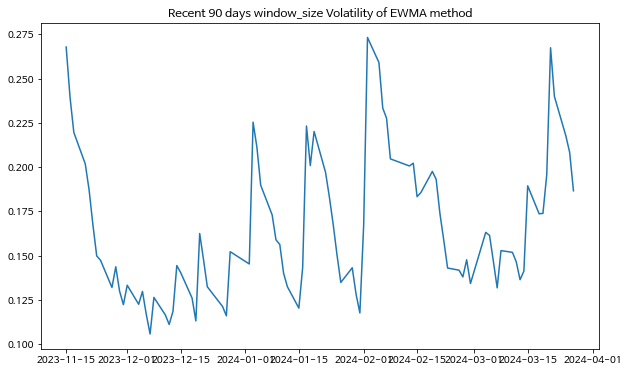

In [33]:
estimator = EWMA(historical_prices,10,0.8)
estimator.estimate()
display(estimator.data.head())
estimator.visualize()

### GARCH
$$
\sigma_n=\sqrt{\alpha\bar\sigma^2+(1-\alpha)\left(\lambda\sigma^2_{n-1}+(1-\lambda)R^2_n\right)}
$$

In [34]:
class GARCH(ARCH, EWMA):
    def __init__(self, data, window_size, alpha, Lambda, visualize_size=90):
        super().__init__(data, window_size, visualize_size)
        self.alpha = alpha
        self.Lambda = Lambda
    
    def estimate(self, UseModel=False):
        if not UseModel :
            self.cal_window_size_Variance()
            self.cal_long_run_vol()
            ini_var = self.data['window_size Variance'][self.window_size]
            sigma_squared_values = [np.NAN]*(self.window_size-1)+[ini_var]  # 초기 변동성의 제곱값을 리스트에 추가
            R_squared_values = self.data['Daily Return'].pow(2)[self.window_size:]
            # R_squared_values를 순회하며 점화식에 따라 변동성의 제곱값을 계산
            a_LongRunVol = self.alpha*self.LongRunVol
            for R_squared in R_squared_values:
                new_sigma_squared = a_LongRunVol + (1-self.alpha)*(self.Lambda * sigma_squared_values[-1] + (1 - self.Lambda) * R_squared)
                sigma_squared_values.append(new_sigma_squared)
            self.data[f'{self.__class__.__name__}_Var'] = sigma_squared_values
            self.cal_annualized_volatility()

        else :
            model = arch_model(self.data['Daily Return'][1:]*100, vol='GARCH') #모델 적합을 위해 100을 곱해 스케일 조정
            model_fit = model.fit(disp='off')
            display(model_fit.summary())
            result = np.array(model_fit.conditional_volatility/100)*(252**0.5) #다시 100으로 나누어 원래의 스케일로 조정
            tmp =[np.NaN]*(len(self.data)-len(result))
            result = np.concatenate((tmp,result))
            self.data[f'{self.__class__.__name__}_Vol_package'] = result

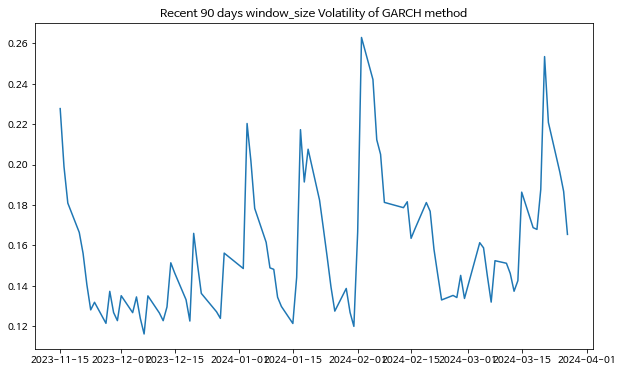

In [35]:
estimator = GARCH(historical_prices,10,0.1,0.8)
estimator.estimate()
estimator.visualize()

## Visualize together
* plot의 범례에서 각 method를 선택하여 시각화 on/off 선택 가능

In [36]:
'''def visualize_together(method_li) :
    plt.figure(figsize=(10,6))
    for method in method_li :
        method.estimate()
        plt.plot(method.data['Date'][-method.visualize_size:],method.data[f'{method.__class__.__name__}_Vol'][-method.visualize_size:], label= f'{method.__class__.__name__}')
        try :
            method.estimate(UseModel=True)
            #display(method.data)
            plt.plot(method.data['Date'][-method.visualize_size:],method.data[f'{method.__class__.__name__}_Vol_package'][-method.visualize_size:], label= f'{method.__class__.__name__}_package')
        except :
            pass
    plt.title(f'Recent {method_li[0].visualize_size} days Annualized Volatility of {len(method_li)} method')
    plt.legend()
    plt.show()'''

"def visualize_together(method_li) :\n    plt.figure(figsize=(10,6))\n    for method in method_li :\n        method.estimate()\n        plt.plot(method.data['Date'][-method.visualize_size:],method.data[f'{method.__class__.__name__}_Vol'][-method.visualize_size:], label= f'{method.__class__.__name__}')\n        try :\n            method.estimate(UseModel=True)\n            #display(method.data)\n            plt.plot(method.data['Date'][-method.visualize_size:],method.data[f'{method.__class__.__name__}_Vol_package'][-method.visualize_size:], label= f'{method.__class__.__name__}_package')\n        except :\n            pass\n    plt.title(f'Recent {method_li[0].visualize_size} days Annualized Volatility of {len(method_li)} method')\n    plt.legend()\n    plt.show()"

In [37]:
def visualize_together(method_li):
    fig = go.Figure()

    for method in method_li:
        method.estimate()
        fig.add_trace(go.Scatter(x=method.data['Date'][-method.visualize_size:],
                                 y=method.data[f'{method.__class__.__name__}_Vol'][-method.visualize_size:],
                                 mode='lines',
                                 name=f'{method.__class__.__name__}'))
        
        try:
            method.estimate(UseModel=True)
            fig.add_trace(go.Scatter(x=method.data['Date'][-method.visualize_size:],
                                     y=method.data[f'{method.__class__.__name__}_Vol_package'][-method.visualize_size:],
                                     mode='lines',
                                     name=f'{method.__class__.__name__}_package'))
        except:
            pass

    fig.update_layout(title=f'Recent {method_li[0].visualize_size} days Annualized Volatility of {len(method_li)} method',
                      xaxis_title='Date',
                      yaxis_title='Annualized Volatility',
                      legend_title='Method')
    fig.show()

In [38]:
MovingWindow_estimator = MovingWindow(historical_prices,10)
ARCH_estimator = ARCH(historical_prices,10,0.31)
EWMA_estimator = EWMA(historical_prices,10,0.94)
GARCH_estimator = GARCH(historical_prices,10,0.148,0.94)

method_li1 =[MovingWindow_estimator,ARCH_estimator,EWMA_estimator,GARCH_estimator]

In [39]:
visualize_together(method_li1)

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:           Daily Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -7452.85
Distribution:                  Normal   AIC:                           14911.7
Method:            Maximum Likelihood   BIC:                           14931.1
                                        No. Observations:                 4698
Date:                Sat, Mar 30 2024   Df Residuals:                     4697
Time:                        15:40:02   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0417  1.715e-02      2.431  1.505e-02 [8.083e-03,7.533e-02]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          1.0412  4.051e-02     25.705 1.036e-145 [  0.962,  1.121]
alpha[1]       0.3586  5.130e-02      6.990  2.745e-12 [  0.258,  0.459]
========================================================================

Covariance estimator: robust
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:           Daily Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7011.44
Distribution:                  Normal   AIC:                           14030.9
Method:            Maximum Likelihood   BIC:                           14056.7
                                        No. Observations:                 4698
Date:                Sat, Mar 30 2024   Df Residuals:                     4697
Time:                        15:40:02   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0439  1.433e-02      3.061  2.203e-03 [1.578e-02,7.193e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0200  5.667e-03      3.532  4.121e-04 [8.910e-03,3.112e-02]
alpha[1]       0.0730  1.033e-02      7.069  1.565e-12 [5.277e-02,9.326e-02]
beta[1]        0.9127  1.286e-02     70.983      0.000     [  0.887,  0.938]
============================================================================

Covariance estimator: robust
"""

## Beyond Close-Close Estimators: Range-based Estimation of Volatility

### Traditional close-to-close measure
$$
\hat\sigma_{cc} = \sqrt{\frac{1}{n}\sum^n_{i=1}\left(\log\left(\frac{C_i}{C_{i-1}}\right)\right)^2}
$$

$$
\hat\sigma_{acc} = \sqrt{\frac{1}{n-1}\sum^n_{i=1}\left(\left(\log\left(\frac{C_i}{C_{i-1}}\right)\right)^2-\frac{\left(\log\left(\frac{C_n}{C_{0}}\right)\right)^2}{n(n-1)}\right)}
$$

In [40]:
class TraditionalCtoC(Abstract_VolEstimator) :
    def __init__(self, data, window_size, visualize_size=90):
        super().__init__(data, window_size, visualize_size)
    
    def estimate(self,isdrift=False):
        if not isdrift :
            sigma_cc_list = []
            for i in range(len(self.data)-self.window_size+1) :
                winodw_prices = np.array(self.data['Close'][i:i+self.window_size])
                log_returns = np.log(winodw_prices[1:]/winodw_prices[:-1])
                #print(log_returns.values)
                sigma_cc = np.sqrt(np.sum(log_returns**2)/self.window_size)
                sigma_cc_list.append(sigma_cc)
            sigma_cc_list = [np.NAN]*(self.window_size-1) + sigma_cc_list
            self.data[f'{self.__class__.__name__}_Vol'] = np.array(sigma_cc_list)*(252**0.5)
        else :
            sigma_acc_list = []
            for i in range(len(self.data)-self.window_size+1) :
                winodw_prices = np.array(self.data['Close'][i:i+self.window_size])
                log_returns = np.log(winodw_prices[1:]/winodw_prices[:-1])
                total_log_return_squared = (np.log(winodw_prices[-1] / winodw_prices[0]))**2
                sigma_acc = np.sqrt((1/(self.window_size-1))*(np.sum(log_returns**2-(total_log_return_squared**2)/(self.window_size*(self.window_size-1)))))
                sigma_acc_list.append(sigma_cc)
            sigma_acc_list = [np.NAN]*(self.window_size-1) + sigma_acc_list    
            self.data[f'{self.__class__.__name__}_Vol'] = np.array(sigma_acc_list)*(252**0.5)

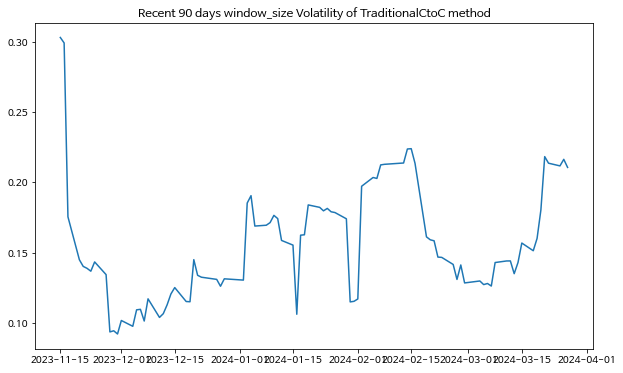

In [41]:
estimator = TraditionalCtoC(historical_prices,10)
estimator.estimate()
estimator.visualize()

### Parkinson (1980)
$$
\hat{\sigma}_{p} = \sqrt{\frac{1}{4n \log(2)} \sum_{i=1}^{n} \left( \log \left(\frac{H_i}{L_i}\right) \right)^2}
$$

In [42]:
class Parkinson(Abstract_VolEstimator) :
    def __init__(self, data, window_size, visualize_size=90):
        super().__init__(data, window_size, visualize_size)
    
    def estimate(self):
        sigma_p_list = []
        for i in range(len(self.data) - self.window_size + 1):
            window_H = np.array(self.data['High'][i:i+self.window_size])
            window_L = np.array(self.data['Low'][i:i+self.window_size])
            
            log_hl = np.log(window_H / window_L)**2
            sigma_p = np.sqrt(np.sum(log_hl) / (4 * self.window_size * np.log(2)))
            
            sigma_p_list.append(sigma_p)
        sigma_p_list = [np.NAN]*(self.window_size-1) + sigma_p_list
        self.data[f'{self.__class__.__name__}_Vol'] = np.array(sigma_p_list)*(252**0.5)

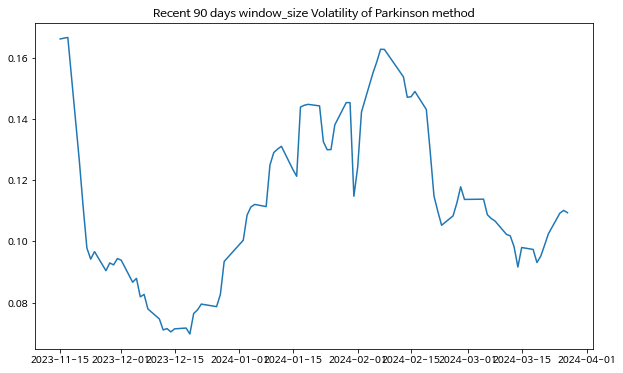

In [43]:
estimator = Parkinson(historical_prices,10)
estimator.estimate()
estimator.visualize()

### Garman & Klass (1980)
$$
\hat{\sigma}_{gk} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} \left[ 0.511 \left( \log \frac{H_i}{L_i} \right)^2 - 0.019\log\frac{C_i}{O_i}\log\frac{H_i L_i}{O_i^2}-2\log\frac{H_i}{O_i}\log\frac{L_i}{O_i}\right]}
$$

In [44]:
class GarmanKlass(Abstract_VolEstimator) :
    def __init__(self, data, window_size, visualize_size=90):
        super().__init__(data, window_size, visualize_size)
    
    def estimate(self):
        sigma_gk_list = []

        for i in range(len(self.data) - self.window_size + 1):
            window_H = np.array(self.data['High'][i:i+self.window_size])
            window_L = np.array(self.data['Low'][i:i+self.window_size])
            window_C = np.array(self.data['Close'][i:i+self.window_size])
            window_O = np.array(self.data['Open'][i:i+self.window_size])
            
            term1 = 0.511 * (np.log(window_H / window_L))**2
            term2 = -0.019 * np.log(window_C / window_O) * np.log(window_H * window_L / window_O**2)
            term3 = -2 * np.log(window_H / window_O) * np.log(window_L / window_O)
            sigma_gk = np.sqrt(np.sum(term1 + term2 + term3) / self.window_size)
            
            sigma_gk_list.append(sigma_gk)
        sigma_gk_list = [np.NAN]*(self.window_size-1) + sigma_gk_list
        self.data[f'{self.__class__.__name__}_Vol'] = np.array(sigma_gk_list)*(252**0.5)

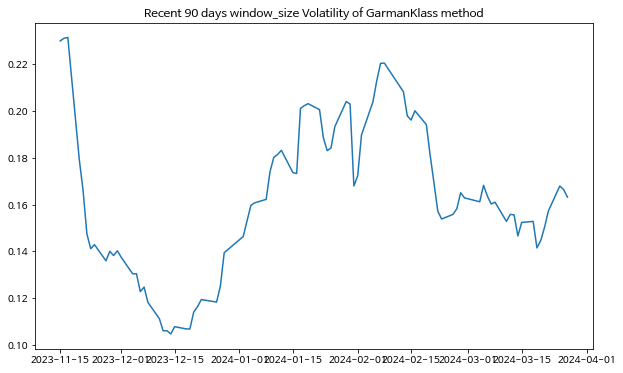

In [45]:
estimator = GarmanKlass(historical_prices,10)
estimator.estimate()
estimator.visualize()

### Rogers & Satchell (1991)
$$
\hat{\sigma}_{rs} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} \left[ \ln \frac{H_i}{C_i} \cdot \ln \frac{H_i}{O_i} + \ln \frac{L_i}{C_i} \cdot \ln \frac{L_i}{O_i} \right]}
$$

In [46]:
class RogersSatchell(Abstract_VolEstimator) :
    def __init__(self, data, window_size, visualize_size=90):
        super().__init__(data, window_size, visualize_size)
    
    def estimate(self) :
        sigma_rs_list = []

        for i in range(len(self.data) - self.window_size + 1):
            window_H = np.array(self.data['High'][i:i+self.window_size])
            window_L = np.array(self.data['Low'][i:i+self.window_size])
            window_C = np.array(self.data['Close'][i:i+self.window_size])
            window_O = np.array(self.data['Open'][i:i+self.window_size])
            
            term1 = np.log(window_H / window_C) * np.log(window_H / window_O)
            term2 = np.log(window_L / window_C) * np.log(window_L / window_O)
            sigma_rs = np.sqrt(np.sum(term1 + term2) / self.window_size)
            
            sigma_rs_list.append(sigma_rs)
        sigma_rs_list = [np.NAN]*(self.window_size-1) + sigma_rs_list
        self.data[f'{self.__class__.__name__}_Vol'] = np.array(sigma_rs_list)*(252**0.5)

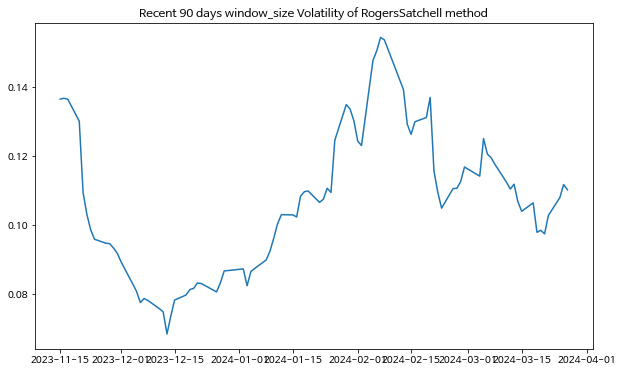

In [47]:
estimator = RogersSatchell(historical_prices,10)
estimator.estimate()
estimator.visualize()

## Visualize together

In [48]:
TraditionalCtoC_estimator = TraditionalCtoC(historical_prices,10)
Parkinson_estimator = Parkinson(historical_prices,10)
GarmanKlass_estimator = GarmanKlass(historical_prices,10)
RogersSatchell_estimator = RogersSatchell(historical_prices,10)

method_li2 =[TraditionalCtoC_estimator,Parkinson_estimator,GarmanKlass_estimator,RogersSatchell_estimator]

In [49]:
visualize_together(method_li2)

## Visualize all together

In [50]:
visualize_together(method_li1+method_li2)

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:           Daily Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -7452.85
Distribution:                  Normal   AIC:                           14911.7
Method:            Maximum Likelihood   BIC:                           14931.1
                                        No. Observations:                 4698
Date:                Sat, Mar 30 2024   Df Residuals:                     4697
Time:                        15:40:19   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0417  1.715e-02      2.431  1.505e-02 [8.083e-03,7.533e-02]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          1.0412  4.051e-02     25.705 1.036e-145 [  0.962,  1.121]
alpha[1]       0.3586  5.130e-02      6.990  2.745e-12 [  0.258,  0.459]
========================================================================

Covariance estimator: robust
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:           Daily Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7011.44
Distribution:                  Normal   AIC:                           14030.9
Method:            Maximum Likelihood   BIC:                           14056.7
                                        No. Observations:                 4698
Date:                Sat, Mar 30 2024   Df Residuals:                     4697
Time:                        15:40:19   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0439  1.433e-02      3.061  2.203e-03 [1.578e-02,7.193e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0200  5.667e-03      3.532  4.121e-04 [8.910e-03,3.112e-02]
alpha[1]       0.0730  1.033e-02      7.069  1.565e-12 [5.277e-02,9.326e-02]
beta[1]        0.9127  1.286e-02     70.983      0.000     [  0.887,  0.938]
============================================================================

Covariance estimator: robust
"""

## Reference
* Paul Wilmott on Quantitiative Finance Ch49
* https://www.investopedia.com/articles/07/ewma.asp
* https://dojang.io/mod/page/view.php?id=2388